In [32]:
import faiss
index = faiss.read_index("multi1MImageVectors.index")

In [33]:
import faiss
import numpy as np

def extract_vectors(index):
    d = index.d
    ntotal = index.ntotal
    vectors = np.zeros((ntotal, d), dtype=np.float32)
    for i in range(ntotal):
        vectors[i, :] = index.reconstruct(i)
    print(len(vectors))
    return vectors[:1000]
vectors = extract_vectors(index)

1000000


In [35]:
from annoy import AnnoyIndex
import numpy as np
t = AnnoyIndex(index.d, 'euclidean') 

for i in range(len(vectors)):
    t.add_item(i, vectors[i])

t.build(10)
t.save('image1000Annoy.ann')


True

<h1> Annoy Index Load <h1>

In [1]:
from annoy import AnnoyIndex
f = 1152 
t = AnnoyIndex(f, 'euclidean')
t.load('image1000Annoy.ann') 


True

<h1> Input Image Vector Conversion <h1>

In [2]:
import torch
from transformers import AutoModel, AutoProcessor
from torchvision import transforms
from PIL import Image
import numpy as np
Imagemodel = AutoModel.from_pretrained("google/siglip-so400m-patch14-384", low_cpu_mem_usage=True)
processor = AutoProcessor.from_pretrained("google/siglip-so400m-patch14-384", low_cpu_mem_usage=True, do_rescale=False)
device_type = "cpu"
device = torch.device(device_type)
Imagemodel.to(device)
path = "static/images/person.jpg"
newImage = Image.open(path)
transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
inputs = transform(newImage)
inputs = (inputs - inputs.min()) / (inputs.max() - inputs.min())
inputs = processor(images=inputs, return_tensors="pt").to(device)
features = Imagemodel.get_image_features(**inputs)
features = np.array(features.tolist())

In [3]:
features.shape

(1, 1152)

<h1> Get Similar Path List<h1>

In [4]:
def indices_to_images(indices):
    image_paths = []
    for i in indices:
        folder_name = i // 1000
        file_name = i % 1000
        folder_str = f"{folder_name:04d}"
        file_str = f"{file_name:03d}.jpg"
        image_paths.append("images" + "/" + folder_str + "/" + file_str)
    return image_paths
        
def ImageSimilar(features, k):
    n_neighbors = k
    include_distances = True  
    indices, distances = t.get_nns_by_vector(features[0], n_neighbors, include_distances=include_distances)
    for i, dist in zip(indices, distances):
        print(f"Index: {i}, Distance: {dist}")
    similarPath = indices_to_images(indices)
    return similarPath

In [5]:
def get_true_positives(similar_paths, desired_label):
    total_occurences = 0
    for filepath in similar_paths:
        yolo_results_list = Yolomodel([filepath], verbose=False)
        for result in yolo_results_list[0]:
            img_label = result.names[int(result.boxes.cls[0])]
            # confidence_score = float(result.boxes.conf[0])
            if img_label == desired_label:
                total_occurences += 1
                break
    return total_occurences

In [8]:
import json
from ultralytics import YOLO
input_image_label = "person"
# Load the dictionary from the json file
with open('ground_truth.json', 'r') as f:
    ground_truth = json.load(f)
print(ground_truth[input_image_label])
similarPath = ImageSimilar(features, ground_truth[input_image_label])
Yolomodel = YOLO('yolov8x.pt')
total_positive_found = get_true_positives(similarPath, input_image_label)
print(total_positive_found)
accuracy = total_positive_found/ground_truth[input_image_label]
print(accuracy)


281
Index: 999, Distance: 16.004003524780273
Index: 133, Distance: 17.624547958374023
Index: 342, Distance: 18.59499740600586
Index: 493, Distance: 19.079057693481445
Index: 31, Distance: 19.09862518310547
Index: 0, Distance: 19.14895248413086
Index: 272, Distance: 19.232383728027344
Index: 794, Distance: 19.3040714263916
Index: 377, Distance: 19.360637664794922
Index: 520, Distance: 19.435853958129883
Index: 64, Distance: 19.486520767211914
Index: 903, Distance: 19.619199752807617
Index: 683, Distance: 19.65833854675293
Index: 171, Distance: 19.69956398010254
Index: 774, Distance: 19.879112243652344
Index: 510, Distance: 19.931520462036133
Index: 615, Distance: 19.954423904418945
Index: 222, Distance: 19.983171463012695
Index: 717, Distance: 20.03748321533203
Index: 979, Distance: 20.09658432006836
Index: 533, Distance: 20.113340377807617
Index: 819, Distance: 20.14885139465332
Index: 75, Distance: 20.159385681152344
Index: 506, Distance: 20.21953773498535
Index: 645, Distance: 20.249

<h1> Visualization of Similar Images <h1>

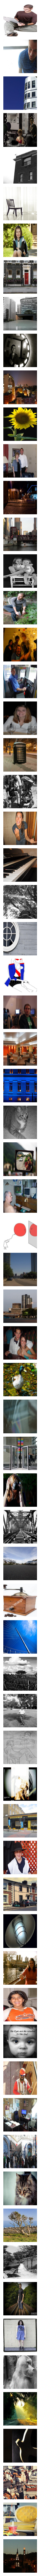

In [9]:
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import requests
from io import BytesIO
res = []
fig = plt.figure(figsize=(100., 100.))
noRows = max(1, len(similarPath)//4)
grid = ImageGrid(fig,111,
                 nrows_ncols=(noRows, 100//noRows),
                 axes_pad=0.1,
                 )
for path in similarPath:
    url = "https://storage.googleapis.com/vislang-public/sbu-{}".format(path)
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize((150, 150), resample=Image.BILINEAR)
    res.append(img)



for ax, im in zip(grid, res):
    ax.imshow(im)
    ax.axis('off')

_ = plt.show()